In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import time

%matplotlib inline

# Preprocessing data

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes



## load and show data

In [3]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_dataset()

In [4]:
print("train_set_x_orig's shape: ", train_set_x_orig.shape)
print("test_set_x_orig's shape: ", test_set_x_orig.shape)
print("train_set_y_orig's shape: ", train_set_y_orig.shape)
print("test_set_y_orig's shape: ", test_set_y_orig.shape)
print("classes's shape: ", classes.shape)
print("number of training example: ", train_set_x_orig.shape[0])
print("number of testing example: ", test_set_x_orig.shape[0])

train_set_x_orig's shape:  (209, 64, 64, 3)
test_set_x_orig's shape:  (50, 64, 64, 3)
train_set_y_orig's shape:  (1, 209)
test_set_y_orig's shape:  (1, 50)
classes's shape:  (2,)
number of training example:  209
number of testing example:  50


In [5]:
# show the image

def showImg(index):
    index = 5
    plt.imshow(train_set_x_orig[index,:])
    print("The image at index: {} is a {}'s picture.\nWhich have y(label) = {}".format(index, classes[np.squeeze(train_set_y_orig[:,index])].decode(), train_set_y_orig[:, index]))

The image at index: 5 is a non-cat's picture.
Which have y(label) = [0]


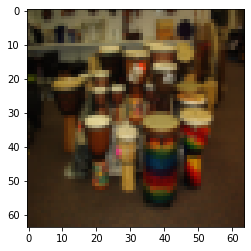

In [6]:
showImg(5)

## flatten data and  standardize data
- because in here 1 image has shape (64,64,3) that is height, width, color so we need to flatten image into (64\*64\*3,1) attributes for training model.
- and each attribute have the value between (0,255) so we standardize it into (0,1)

In [7]:
train_set_x = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T / 255
test_set_x = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T / 255

print("train_set_xs shape: ", train_set_x.shape)
print("test_set_x's shape: ", test_set_x.shape)
print("number of training example: ", train_set_x.shape[1])
print("number of testing example: ", test_set_x.shape[1])

train_set_xs shape:  (12288, 209)
test_set_x's shape:  (12288, 50)
number of training example:  209
number of testing example:  50


$\to$ Now we have prepare all the data for training

# Build the model
- In here I just want to build a simple model with **no hidden layers and one output layer**. As the image shown below:

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

## Foward propagation
For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$

## Backward propagation

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{5}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{6}$$

## Update parameters
- The update rule is $ \theta = \theta - \alpha \text{ } \frac{\partial J}{\partial \theta}$, where $\alpha$ is the learning rate. In here we need to update $w$ and $b$

$$w = w - \alpha \text{ } \frac{\partial J}{\partial w}\tag{7}$$

$$b = b - \alpha \text{ } \frac{\partial J}{\partial b}\tag{8}$$

In [88]:
class NNmodel:
    def __init__(self):
        pass

    # this use for computing output's activation layer
    def sigmoid(self, z):
        a = 1 / (1 + np.exp(-z))
        return a

    # in here we have no hidden layers
    def initialize_parameters(self, n_feature):
        w = np.zeros((n_feature,1))
        b = np.zeros((1,1))    
        
        assert(w.shape == (n_feature, 1))
        assert(b.shape == (1,1))
        
        return w,b

    def forward_backward(self, X, Y):
        # numbers of training examples
        m = X.shape[1]
        
        # forward
        Z = np.dot(self.w.T, X) + self.b # equation (1)
        A = self.sigmoid(Z) # equation (2)
        
        # compute cost
        cost = -1/m * (np.dot(Y, np.log(A).T) + np.dot(1-Y, np.log(1-A).T)) # equation (4)
        cost = np.squeeze(cost) # [[cost]] -> cost
        
        # backward
        dw = (1/m)*np.dot(X,(A-Y).T) # equation (5)
        db = (1/m)*np.sum(A-Y) # equation (6)
        
        return dw, db, cost

    def fit(self, X_train, Y_train, lr=0.01, iterations=2000):        
        self.w, self.b = self.initialize_parameters(X_train.shape[0])
        self.costs = []
        
        for i in range(iterations):
            dw, db, cost = self.forward_backward(X_train, Y_train)
            self.w = self.w - lr*dw # equation (7)
            self.b = self.b - lr*db # equation (8)
            if i % 100 == 0:
                print("Cost after {} iterations: {}".format(i, cost))
                print()
            self.costs.append(cost)
        
    def accuracy(self, X_train, Y_train, X_test, Y_test):
        Y_prediction_train = np.round(self.sigmoid(np.dot(self.w.T, X_train) + self.b))
        Y_prediction_test = np.round(self.sigmoid(np.dot(self.w.T, X_test) + self.b))
        
        accuracy_train = 100 - np.mean(np.abs(Y_prediction_train - Y_train))*100
        accuracy_test = 100 - np.mean(np.abs(Y_prediction_test - Y_test))*100
        
        print("Accuracy on the train set: {}%".format(accuracy_train))
        print("Accuracy on the test set: {}%".format(accuracy_test))
    
    def predict(self, X_test, Y_test, index):
        z = np.dot(self.w.T, X_test[:,index]) + self.b
        A = np.squeeze(np.round(self.sigmoid(z)))
        plt.imshow(X_test[:,index].reshape((64,64,3)))
        print("True: {}.\tPredict: {}".format(Y_test[:, index], A))
    
    def get_last_cost(self):
        return self.costs[-1]

## Run model

Cost after 0 iterations: 0.6931471805599453

Cost after 100 iterations: 0.823920868162269

Cost after 200 iterations: 0.4189442213534804

Cost after 300 iterations: 0.6173497048572023

Cost after 400 iterations: 0.522115770306867

Cost after 500 iterations: 0.3877087478946796

Cost after 600 iterations: 0.23625445668031037

Cost after 700 iterations: 0.15422213306249977

Cost after 800 iterations: 0.13532782831877796

Cost after 900 iterations: 0.12497148000593815

Cost after 1000 iterations: 0.11647833125883057

Cost after 1100 iterations: 0.10919251128302268

Cost after 1200 iterations: 0.10280446418272836

Cost after 1300 iterations: 0.09712981007970017

Cost after 1400 iterations: 0.09204326923596717

Cost after 1500 iterations: 0.08745251991704941

Cost after 1600 iterations: 0.08328603053562557

Cost after 1700 iterations: 0.07948657037734266

Cost after 1800 iterations: 0.07600734572003641

Cost after 1900 iterations: 0.07280949458435325

Accuracy on the train set: 99.5215311004

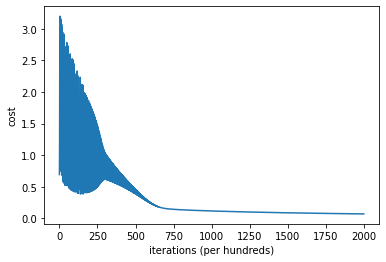

In [119]:
m1 = NNmodel()
m1.fit(train_set_x, train_set_y_orig)
m1.accuracy(train_set_x, train_set_y_orig, test_set_x, test_set_y_orig)
plt.plot(np.squeeze(m1.costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.show()

True: [1].	Predict: 1.0


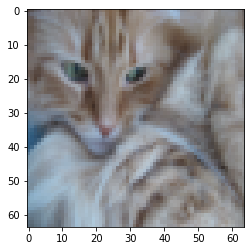

In [103]:
index = 2
m1.predict(train_set_x, train_set_y_orig, index)

Cost after 0 iterations: 0.6931471805599453

Cost after 100 iterations: 0.5845083636993086

Cost after 200 iterations: 0.46694904094655476

Cost after 300 iterations: 0.37600686694802077

Cost after 400 iterations: 0.3314632893282512

Cost after 500 iterations: 0.30327306747438293

Cost after 600 iterations: 0.2798795865826048

Cost after 700 iterations: 0.2600421369258757

Cost after 800 iterations: 0.24294068467796623

Cost after 900 iterations: 0.22800422256726066

Cost after 1000 iterations: 0.21481951378449635

Cost after 1100 iterations: 0.20307819060644988

Cost after 1200 iterations: 0.1925442771670686

Cost after 1300 iterations: 0.18303333796883503

Cost after 1400 iterations: 0.1743985943844888

Cost after 1500 iterations: 0.16652139705400332

Cost after 1600 iterations: 0.15930451829756614

Cost after 1700 iterations: 0.15266732471296504

Cost after 1800 iterations: 0.14654223503982342

Cost after 1900 iterations: 0.14087207570310162

Accuracy on the train set: 99.043062200

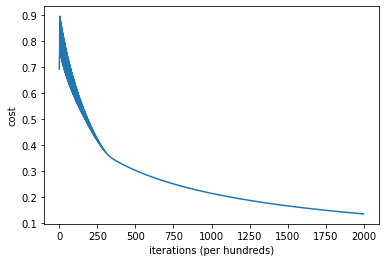

In [118]:
m2 = NNmodel()
m2.fit(train_set_x, train_set_y_orig,lr=0.005, iterations=2000)
m2.accuracy(train_set_x, train_set_y_orig, test_set_x, test_set_y_orig)
plt.plot(np.squeeze(m2.costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.show()